In [1]:
import argparse
import pandas as pd
import numpy as np
import os 

from matplotlib import pyplot as plt

In [142]:
input_path = "./data/raw/2023_set_n1/2023_01_04-00_16_30.csv"
df = pd.read_csv(input_path)
freq = [x for x in df.columns if "CL" in x]
data = df[freq].to_numpy()
time = 0.02 * np.arange(data.shape[0])


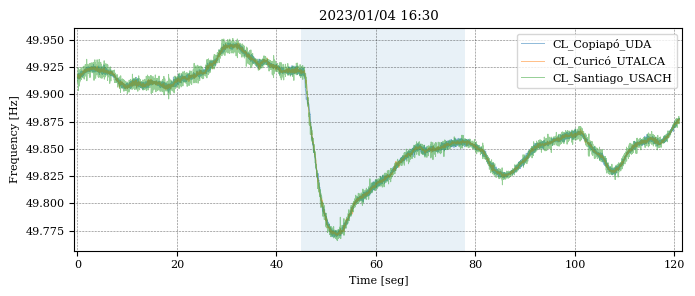

In [143]:
font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)
plt.rcParams['axes.xmargin'] = .005

fig = plt.figure(figsize=(7,3))

t0 = 45
tm = 78
plt.axvspan(t0, tm, alpha=.1)

plt.grid(color='k', linestyle='dotted', linewidth=.4)

plt.plot(time, data, alpha=.5, linewidth=.7)
plt.title("2023/01/04 16:30")
plt.xlabel("Time [seg]")
plt.ylabel("Frequency [Hz]")

plt.legend(freq)

#plt.text( 60.5, 49.815, 'Identification\nInterval', alpha=.3)

fig.tight_layout()

plt.savefig('./img/DataExample.pdf')

In [2]:
import pickle
from scipy import signal

import sys
sys.path.insert(0, ".")
sys.path.insert(0, "./src/")
import models as mdl

In [179]:
## run sumplers and identifications for E1a 
instance = "2023_01_05-00_21_20"
et = 15
model = "B2"
for i in range(10):
    et = et + 5
    sam_dir = f"test/test_interval_exp_paper/{et}"
    parameters = "30,0.56261,0.74232"
    if not os.path.isdir(sam_dir):
                os.makedirs(sam_dir)

    os.system(f"python src/sampler.py -i data/raw/2023_set_n1/{instance}.csv -o {sam_dir} -et {et}")
    for rep in range(11):
        out_dir = f"{sam_dir}/rep{rep}"
        if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
        os.system(f"python src/de_run.py -i {sam_dir}/{instance}_sampled.csv -o {out_dir} -m {model} -p {parameters}")

------------------------------------------------------------------------------------
   input: 2023_01_05-00_21_20_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.0004686363413788175
       x: [ 4.773e+02  7.980e+02  2.442e+01  8.502e-01  8.169e+00]
     nit: 63
    nfev: 9600
------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
   input: 2023_01_05-00_21_20_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.00046846733112647945
       x: [ 4.343e+02  7.311e+02  2.431e+01  8.539e-01 

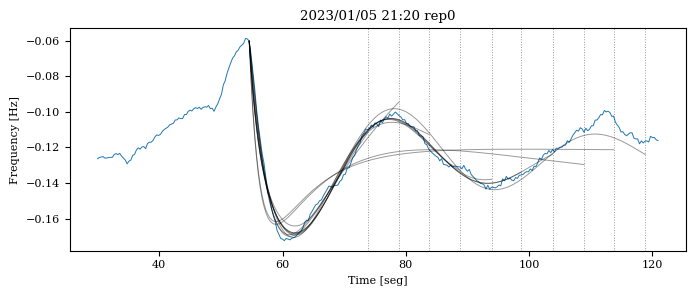

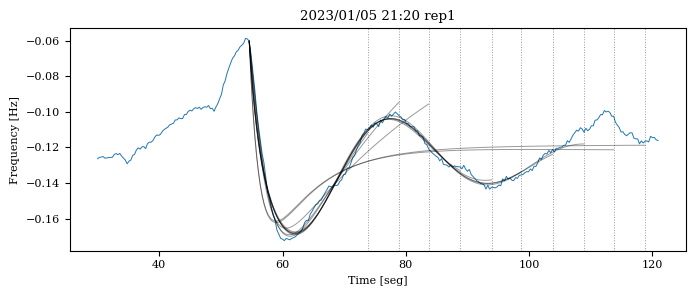

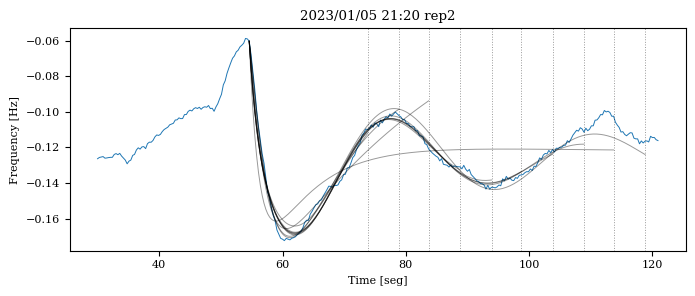

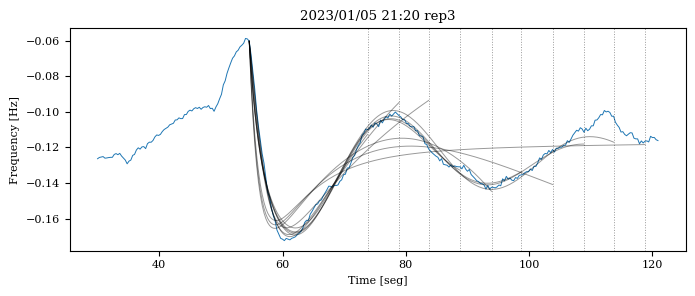

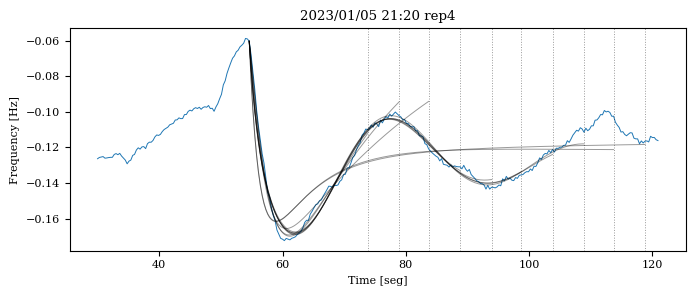

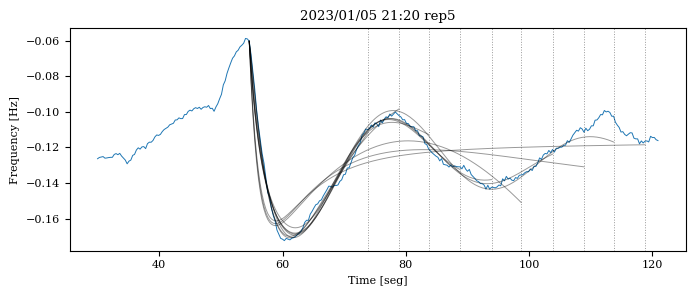

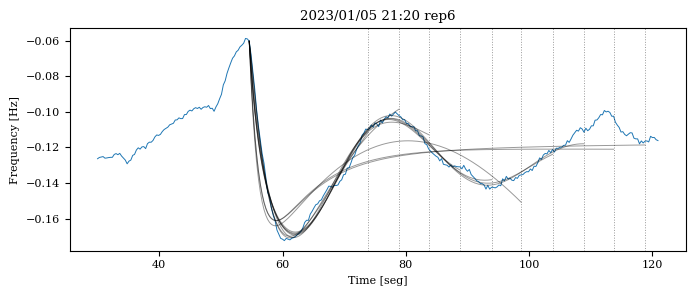

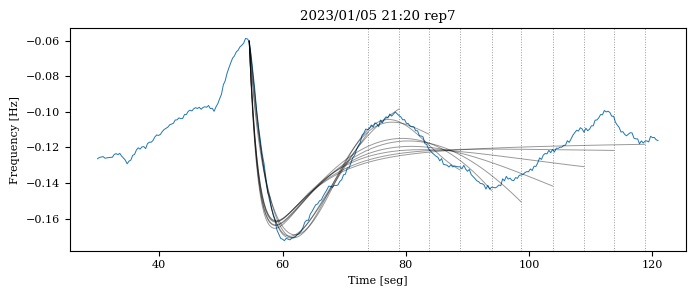

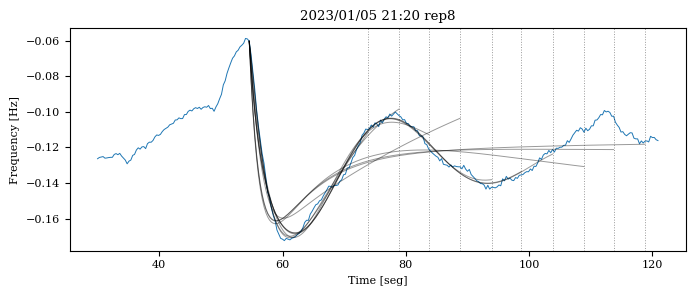

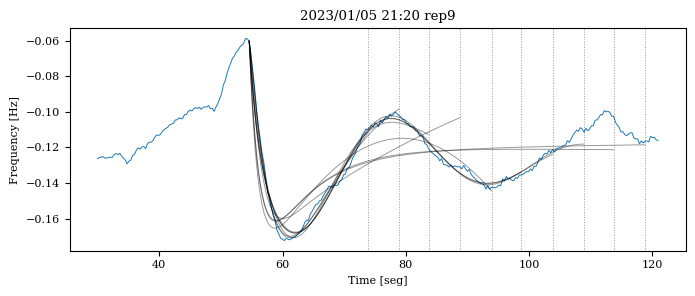

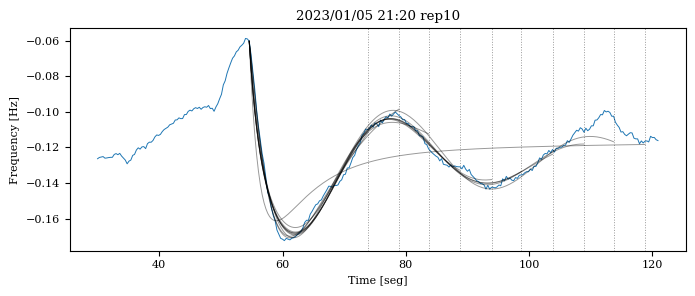

In [17]:
## Fig1 E1a

font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)

instance = "2023_01_05-00_21_20"

model = "B2"

for rep in range(11):
    et = 15
    for i in range(10):
        et = et + 5
        sam_dir = f"test/test_interval_exp_paper/{et}"
        out_dir = f"{sam_dir}/rep{rep}"
        
        file = open(f"{out_dir}/{instance}_sampled_result.p", 'rb')
        result = pickle.load(file)
        file.close()
        x = result.x
        df = pd.read_csv(f"{sam_dir}/{instance}_sampled.csv")  
        Ts = df["time"][1]
        P0 = -df["power"][0] / 1000
        event_freq = df["delta_freq"][df["event"]==1].to_numpy()

        if model == "b":
            sys = mdl.modelo_b(x, Ts)
        elif model == "c":
            sys = mdl.modelo_c(x, Ts)
        elif model == "cc":
            sys = mdl.modelo_cc(x, Ts)
            ########################################
        elif model == "A1":
            sys = mdl.modelo_A1(x, Ts)
        elif model == "A2":
            sys = mdl.modelo_A2(x, Ts)
        elif model == "B1":
            sys = mdl.modelo_B1(x, Ts)
        elif model == "B2":
            sys = mdl.modelo_B2(x, Ts)

        sim_power = P0 * np.repeat(1, event_freq.shape)
        sim = signal.dlsim(sys, sim_power, x0 = event_freq[0])
        sim_freq = sim[1].ravel()

        real_time = df["time"].to_numpy()
        real_freq = df["delta_freq"].to_numpy()

        event_time = df["time"][df["event"]==1].to_numpy()

        sim_time = np.linspace(event_time[0],event_time[-1],num=sim_freq.size)

        if i == 0:
            fig = plt.figure(figsize=(7,3))
            plt.plot(real_time[100:], real_freq[100:], linewidth=.7)
            plt.title(f"2023/01/05 21:20 rep{rep}")
            plt.xlabel("Time [seg]")
            plt.ylabel("Frequency [Hz]")


        plt.plot(sim_time,sim_freq, alpha=.4, linewidth=.7, color = "k")
        plt.axvline(sim_time[-1], alpha=.4, linewidth=.7, color = "k", linestyle='dotted')

    fig.tight_layout()
    plt.savefig(f"./img/ExpIntervalSims{rep}.pdf")

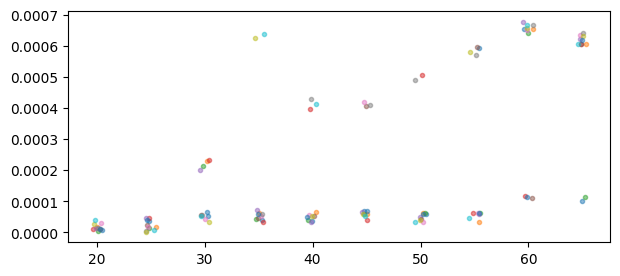

In [3]:
## Save this idea for E3

instance = "2023_01_05-00_21_20"

ERR = []
et = 15

ETS = [et + 5*(i+1) for i in range(10)]

for i in range(10):
    et = et + 5
    err = []    
    for rep in range(11):
        sam_dir = f"test/test_interval_exp_paper/{et}"
        out_dir = f"{sam_dir}/rep{rep}"

        file = open(f"{out_dir}/{instance}_sampled_result.p", 'rb')
        result = pickle.load(file)
        file.close()
        err.append(result.fun/et)
    ERR.append(err)
    
fig = plt.figure(figsize=(7,3))


for rep in range(11):
    jitterETS = ETS.copy()
    jitterERR = [ERR[i][rep] for i in range(10)]
    for i in range(10):
        jitterETS[i] = jitterETS[i] + .5*(2*np.random.rand()-1)
        jitterERR[i] = jitterERR[i] + .00002*(2*np.random.rand()-1)
        
    plt.plot(jitterETS, jitterERR, marker = ".", linestyle="", alpha = .5)
plt.show()

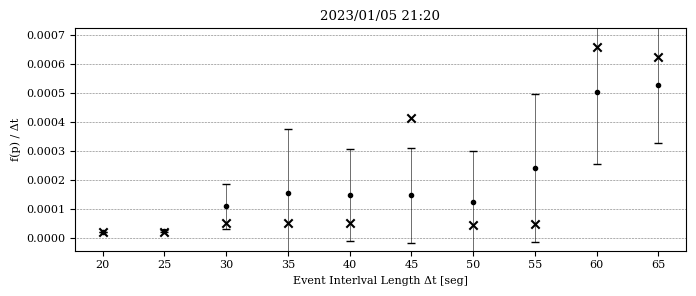

In [39]:
## fig2 E1a

font = {'family' : 'serif',
        'size'   : 8}

plt.rc('font', **font)

instance = "2023_01_05-00_21_20"

fig = plt.figure(figsize=(7,3))
rep = 6
err = [ERR[i][rep] for i in range(10)]


npERR = np.array(ERR)
err_means = [npERR[i].mean() for i in range(10)]
err_sd = [npERR[i].std() for i in range(10)]
plt.errorbar(ETS, err_means, err_sd, color='k', linewidth=.4, linestyle='None', marker='.', capsize=3)

plt.scatter(ETS, err, color = "k", marker = "x")
#plt.title("2023/01/04 16:30")
plt.title("2023/01/05 21:20")

plt.xlabel("Event Interlval Length Δt [seg]")
plt.ylabel("f(p) / Δt")
plt.grid(axis = 'y', color='k', linestyle='dotted', linewidth=.4)
fig.tight_layout()

d=.1*(max(err)-min(err))
plt.ylim([min(err)-d,max(err)+d])
plt.xticks(ETS)
plt.show()


plt.savefig(f"./img/ExpIntervalErrs{rep}.pdf")

In [178]:

#instance = "2023_01_05-00_21_20"

instance = "2023_01_04-00_16_30"
output_dir = f"test/test_new_models/"
et = 37

model = "B2"
parameters = "30,0.56261,0.74232"

f"python src/sampler.py -i data/raw/2023_set_n1/{instance}.csv -o {output_dir} -et {et}"

os.system(f"python src/sampler.py -i data/raw/2023_set_n1/{instance}.csv -o {output_dir} -et {et}")
os.system(f"python src/de_run.py -i {output_dir}{instance}_sampled.csv -o {output_dir} -m {model} -p {parameters}")



hat_K = 51.53779438254718
hat_H = 2.0615117753018875

hat_Kd = 0.6743430474740779

bounds = [(1e-05, 1000), (1e-05, 1000), (1e-05, 1000), (0.020615117753018893, 4.102408432850756), (0.2023029142422234, 1.1463831807059324)]

------------------------------------------------------------------------------------
   input: 2023_01_04-00_16_30_sampled.csv 

          model: B2
             Ts: 0.3

        popsize: 30
       mutation: 0.56261
  recombination: 0.74232
        maxiter: 1000
            tol: 0.01


 message: Optimization terminated successfully.
 success: True
     fun: 0.001760582680079878
       x: [ 1.710e+01  2.704e+01  7.960e+00  7.135e-01  6.995e-01]
     nit: 102
    nfev: 15450
------------------------------------------------------------------------------------


0